# Cell turnover and anisomycin analyses 

This notebook contains analyses related to cell turnover, how it relates to learning, and how anisomcyin disrupts cell turnover.

In [1]:
# Import useful modules
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

In [2]:
print(plt.rcParams['font.family'])
plt.rcParams['font.sans-serif']

['sans-serif']


['DejaVu Sans',
 'Bitstream Vera Sans',
 'Computer Modern Sans Serif',
 'Lucida Grande',
 'Verdana',
 'Geneva',
 'Lucid',
 'Arial',
 'Helvetica',
 'Avant Garde',
 'sans-serif']

Add repositories to path so you can use them for analyses. There has to be a better way to do this.

In [3]:
# Import project specific modules and enable automatic reloading
import sys
from pathlib import Path
import os
eraser_path = Path(os.getcwd()).parent
reinstatement_path = eraser_path.parent / 'FearReinstatement'
sys.path.append(str(eraser_path))
sys.path.append(str(reinstatement_path))

import discrimination as discr
%load_ext autoreload
%autoreload 2

Import and set up group data class

In [5]:
import placefield_stability
pfg = placefield_stability.GroupPF()
pfg._load()
groups = [pfg.nlmice, pfg.lmice, pfg.amice]

First, recapitulate results that turnover BETWEEN arenas predicts learning (higher turnover = better discrimination/learning)

<AxesSubplot:title={'center':'Between Arenas'}, ylabel='Cell Overlap Ratio\nDay -2 to Day -2'>

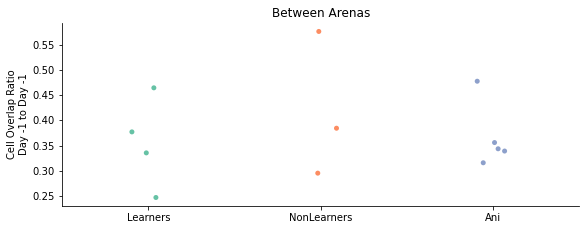

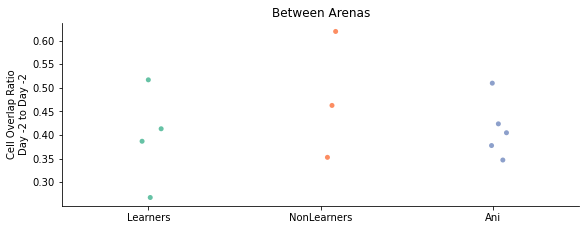

In [4]:
pfg.drift_by_group(-1, -1, within_arena=False, drift_type='overlap')
pfg.drift_by_group(-2, -2, within_arena=False, drift_type='overlap')

This doesn't look very significant, but then again, the main effect is in EVENT RATE DIFFERENCES between arenas, not turnover. 

Does cell turnover WITHIN an arena ACROSS days before shock predict learning? Hypothesis: day-to-day turnover influences the ability to learn new information, and more turnover frees up neurons to encode new information -> better learning/discrimination between arenas

<AxesSubplot:title={'center':'Within Arena'}, ylabel='Cell Overlap Ratio\nDay -2 to Day -1'>

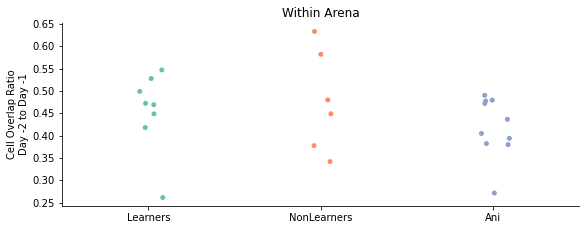

In [5]:
pfg.drift_by_group(-2, -1, within_arena=True, drift_type='overlap')

It seems the first-pass answer is NO, there appears to be no difference between groups based on cell turnover from day -2 to day -1.

One prediction, based on the idea that anisomycin prevents any learning-related plasticity, is that 2d correlations should be HIGHER for ANI vs non-ANI mice following anisomycin administration.  

NaNs detected in data - check!
NaNs detected in data - check!


array([<AxesSubplot:title={'center':'Learners: PV2dboth at optimal rotation'}>,
       <AxesSubplot:title={'center':'Nonlearners: PV2dboth at optimal rotation'}>,
       <AxesSubplot:title={'center':'Ani: PV2dboth at optimal rotation'}>],
      dtype=object)

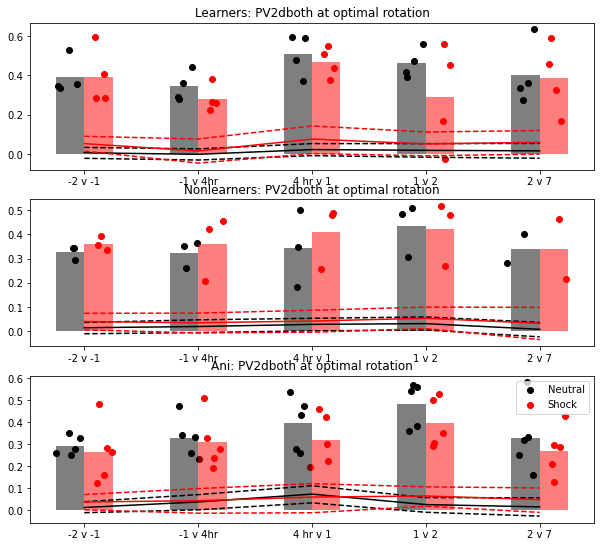

In [6]:
pfg.scatterbar_bw_days(type='PV2dboth')

This does not seem to hold out from the above, however, since by eye the ANI correlations (bottom row) are at best equal to the other groups.

However, maybe this is because we are comparing between time points when plasticity has already occurred: for day -1 to day 4, lots of changes have already occurred from day -1 to day 0 time points.  Same thing for time points after anisomycin administration. Maybe the key time point is day 0 to 4hr, or better yet, day 0 to day 1, sessions?  We only have this data for open field, however.

NaNs detected in data - check!
NaNs detected in data - check!
NaNs detected in data - check!
NaNs detected in data - check!
NaNs detected in data - check!


array([<AxesSubplot:title={'center':'Learners: PV2dboth at optimal rotation'}>,
       <AxesSubplot:title={'center':'Nonlearners: PV2dboth at optimal rotation'}>,
       <AxesSubplot:title={'center':'Ani: PV2dboth at optimal rotation'}>],
      dtype=object)

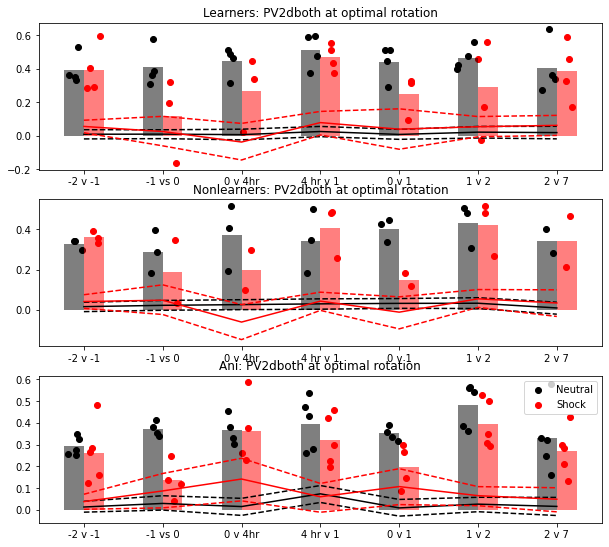

In [7]:
pfg.scatterbar_bw_days(type='PV2dboth', include_dayzero=True)

Ok, this does not seem to pan out either.  The -1 v 0 and 0 v 1 comparisons are basically the same between all groups.  Keep in mind that any red dots in these comparisons are not legit as the mice only spend 60 second in the shock arena on day 0.

That being said, what might be interesting is that there seems to be a higher correlation between the 0 and 4 hour session for the shock arena, even despite there being very little data in the 0 hour session.  Need to think on whether or not this is a legitimate comparison.

One related question is: is cell turnover between arenas related to cell turnover across days? One could imagine that some mice simply have faster turnover of cells in general, and that as a result, they inherently have less similar cellulary activity between any pair of sessions, including between arenas on a given day.

As far as I know, this has not been shown before.

In [7]:
fig.get_size_inches()

array([6., 4.])

Spearman Correlation
r = 0.5604395604395606
p = 0.04634590589406461


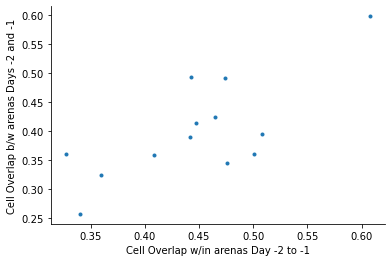

In [6]:
from eraser_reference import all_mice_good

overlap_win, overlap_bw = [], []
for mouse in all_mice_good:
    # Get turnover between arenas on days -2 and -1 and average them
    o_bw_temp = []
    for day in [-2, -1]:
        _, _, oboth, _, _ = placefield_stability.get_overlap(mouse, 'Open', day, 'Shock', day, batch_map=True)
        o_bw_temp.append(oboth)
    overlap_bw.append(np.mean(o_bw_temp))
    
    # Get turnover within each arena from days -2 to -1 and average them
    o_win_temp = []
    for arena in ['Shock', 'Open']:
        _, _, oboth, _, _ = placefield_stability.get_overlap(mouse, arena, -2, arena, -1, batch_map=True)
        o_win_temp.append(oboth)
    overlap_win.append(np.mean(o_win_temp))

fig, ax = plt.subplots()
ax.plot(overlap_win, overlap_bw, '.')
ax.set_xlabel('Cell Overlap w/in arenas Day -2 to -1')
ax.set_ylabel('Cell Overlap b/w arenas Days -2 and -1')
sns.despine(ax=ax)

# Looks like there is a significant correlation with all the points
r, p = stats.spearmanr(overlap_bw, overlap_win)
print('\033[4mSpearman Correlation overlap\033[0m')
print('r = ' + str(r))
print('p = ' + str(p))

Ok, that's pretty cool. There seems to be a pretty nice relationship here. Is it still there if we get rid of that one crazy outlier point in the upper-right.  Has this been shown anywhere before? Seriously, I thought Rubin et al. 2015 maybe but it doesn't appear so...

In [9]:
# This goes away when I remove that outlier
imax = np.argmax(overlap_bw)
npts = len(overlap_bw)
good_bool = np.ones(npts).astype('bool')
good_bool[imax] = 0
r2, p2 = stats.spearmanr(np.asarray(overlap_bw)[good_bool], np.asarray(overlap_win)[good_bool])
print('\033[4mSpearman Correlation\033[0m')
print('r = ' + str(r2))
print('p = ' + str(p2))

Spearman Correlation
r = 0.44055944055944063
p = 0.15173503571673022


Ok, so there definitely is a trend but only with that one outlier point.  Maybe I can get more statistical power by combining with data coming from AFTER learning too, say days 1 to 2?

placefields_cm1_manlims_1000shuf.pkl not found, loading FinalOutput.mat which is slow
placefields_cm1_manlims_1000shuf.pkl not found, loading FinalOutput.mat which is slow
placefields_cm1_manlims_1000shuf.pkl not found, loading FinalOutput.mat which is slow
placefields_cm1_manlims_1000shuf.pkl not found, loading FinalOutput.mat which is slow
placefields_cm1_manlims_1000shuf.pkl not found, loading FinalOutput.mat which is slow
placefields_cm1_manlims_1000shuf.pkl not found, loading FinalOutput.mat which is slow
placefields_cm1_manlims_1000shuf.pkl not found, loading FinalOutput.mat which is slow
Spearman Correlation (overlap ratio) 
r = 0.738119658119658
p = 1.676208180412054e-05
Spearman Correlation (DI ratio) 
r = 0.8830369357045142
p = 2.3529785766730942e-09


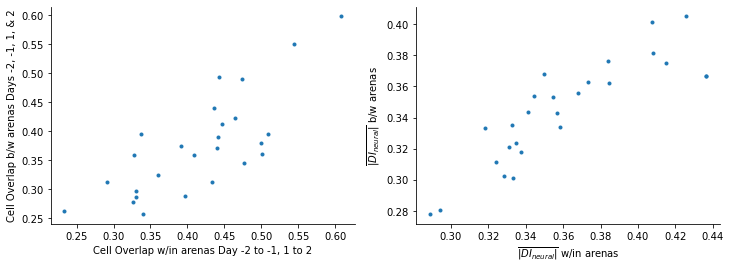

In [11]:
overlap_win_all, overlap_bw_all = [], []
DI_win_all, DI_bw_all = [], []
day_pairs = [[-2, -1], [1, 2]]
for mouse in all_mice_good:
    # Get turnover between arenas on days -2 and -1 and average them
    o_bw_temp = []
    o_win_temp = []
    DI_bw_temp, DI_win_temp = [], []
    for day_pair in day_pairs:
        for day in day_pair:
            _, _, oboth, _, _ = placefield_stability.get_overlap(mouse, 'Open', day, 'Shock', day, batch_map=True)
            o_bw_temp.append(oboth)
            DIneurons = discr.get_DI_scores(mouse, 'Open', day, 'Shock', day, batch_map_use=True)
            DI_bw_temp.append(np.mean(np.abs(DIneurons)))
        overlap_bw_all.append(np.nanmean(o_bw_temp))
        DI_bw_all.append(np.nanmean(DI_bw_temp))

        # Get turnover within each arena from days -2 to -1 and average them

        for arena in ['Shock', 'Open']:
            _, _, oboth, _, _ = placefield_stability.get_overlap(mouse, arena, day_pair[0], arena, day_pair[1], 
                                                                 batch_map=True)
            o_win_temp.append(oboth)
            DIneurons = discr.get_DI_scores(mouse, 'Open', day_pair[0], 'Shock', day_pair[1], batch_map_use=True)
            DI_win_temp.append(np.mean(np.abs(DIneurons)))
        overlap_win_all.append(np.nanmean(o_win_temp))
        DI_win_all.append(np.nanmean(DI_win_temp))
        
        
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(overlap_win_all, overlap_bw_all, '.')
ax[0].set_ylabel('Cell Overlap w/in arenas Day -2 to -1, 1 to 2')
ax[0].set_xlabel('Cell Overlap b/w arenas Days -2, -1, 1, & 2')

ax[1].plot(DI_win_all, DI_bw_all, '.')
ax[1].set_ylabel(r"$\overline{|DI_{neural}|}$ w/in arenas one day later")
ax[1].set_xlabel(r"$\overline{|DI_{neural}|}$ b/w arenas same day")

sns.despine(fig=fig)

# Super significant correlation with all the points
r, p = stats.spearmanr(overlap_win_all, overlap_bw_all)
print('\033[4mSpearman Correlation (overlap ratio) \033[0m')
print('r = ' + str(r))
print('p = ' + str(p))

rdi, pdi = stats.spearmanr(DI_win_all, DI_bw_all)
print('\033[4mSpearman Correlation (DI ratio) \033[0m')
print('r = ' + str(rdi))
print('p = ' + str(pdi))

Spearman Correlation
r = 0.6521739130434784
p = 0.0010049095006007711


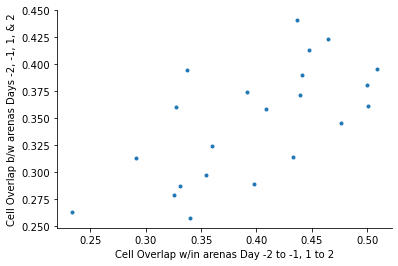

In [11]:
# Cool, still very significant even if I exclude 4 biggest points
ioutlier = np.where(np.asarray(overlap_bw_all) > 0.47)[0]
npts = len(overlap_bw_all)
good_bool = np.ones(npts).astype('bool')
good_bool[ioutlier] = 0
r2, p2 = stats.spearmanr(np.asarray(overlap_win_all)[good_bool], np.asarray(overlap_bw_all)[good_bool])

fig, ax = plt.subplots()
ax.plot(np.asarray(overlap_win_all)[good_bool], np.asarray(overlap_bw_all)[good_bool], '.')
ax.set_xlabel('Cell Overlap w/in arenas Day -2 to -1, 1 to 2')
ax.set_ylabel('Cell Overlap b/w arenas Days -2, -1, 1, & 2')
sns.despine(ax=ax)

print('\033[4mSpearman Correlation\033[0m')
print('r = ' + str(r2))
print('p = ' + str(p2))

# Figure for paper above

# Note: this code is now folded into `placefield_stability.GroupPF.drift_time_v_context()`

No neural data for Marble14: 8/18/2018-s1
Spearman Correlation
r = 0.7347008547008547
p = 1.9205609505225188e-05


(<AxesSubplot:xlabel='Cell Overlap w/in arenas Day -2 to -1, 1 to 2', ylabel='Cell Overlap bw arenas Day -2 ,-1 ,1 ,2'>,
 [0.3598784177986764,
  0.3311584947461993,
  0.5083930296726349,
  0.5000925613946157,
  0.6078490505002313,
  0.5445716771561283,
  0.5002905637645725,
  0.397303362434705,
  0.44714716925568726,
  0.35423846371431783,
  0.3399263428211161,
  0.23355304924650921,
  0.474006419919485,
  0.43624853148225057,
  0.46466770172941735,
  0.43949446266733755,
  0.40834771630189454,
  0.32577518539786887,
  0.3270618314144995,
  0.291411100039047,
  0.4758980911857307,
  0.43262002422053686,
  0.4413074909147747,
  0.3918011377949035,
  0.44213274336283187,
  0.3376732397588722],
 [0.3241320849227449,
  0.28724066677429927,
  0.3953147226173542,
  0.3803952488271065,
  0.5980103514984823,
  0.5507087177423806,
  0.3612834286374401,
  0.2890728490024643,
  0.41326164874551974,
  0.29730522972812234,
  0.25744751591146575,
  0.26327936359117393,
  0.4908510599713472,
  0.4408

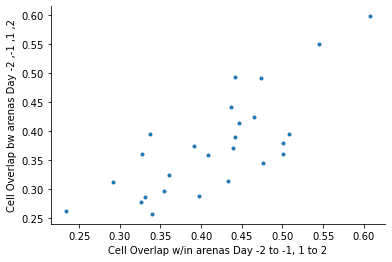

In [12]:
pfg.drift_time_v_context(day_pairs=[[-2, -1], [1, 2]], drift_metric='overlap', speed_thresh=0)

Now verify the above relationship still exists if you look at only cells that are active in both sessions and use event-rate differences as a metric of drift, rather than cell overlap.

First, write some code to pull out event rate differences quickly and easily

In [13]:
import session_directory as sd
import Placefields as pf
mouse = 'Marble07'
arena1, day1 = 'Open', -2
arena2, day2 = 'Shock', -2
batch_map_use = True
speed_thresh = 1
pf_file = 'placefields_cm1_manlims_1000shuf.pkl'
neuron_map = placefield_stability.get_neuronmap(mouse, arena1, day1, arena2, day2, batch_map_use=batch_map_use)
reg_session = sd.find_eraser_session(mouse, arena2, day2)

# Gets PVs
PV1 = pf.get_PV1(mouse, arena1, day1, speed_thresh=speed_thresh, pf_file=pf_file)
PV2 = pf.get_PV1(mouse, arena2, day2, speed_thresh=speed_thresh, pf_file=pf_file)

# Now register between sessions
PV1all, PV2all, PV1both, PV2both = placefield_stability.registerPV(PV1, PV2, neuron_map, reg_session)

deltaER = PV1both - PV2both
DI_ER = (PV1both - PV2both)/(PV1both + PV2both)

The above has been folded into the function `placefield_stability.event_rate_bw_sessions`.  Double check below.

<AxesSubplot:ylabel='Count'>

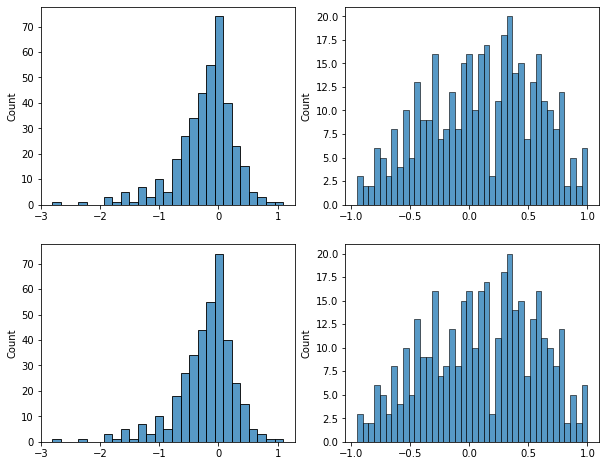

In [14]:
deltaERcheck, DI_ERcheck = placefield_stability.event_rate_bw_sessions(mouse, arena1, day1, arena2, day2, 
                                                                       batch_map_use=batch_map_use, speed_thresh=speed_thresh)

fig, ax = plt.subplots(2,2)
fig.set_size_inches([10, 8])
sns.histplot(data=deltaER - PV2both, ax=ax[0][0])
sns.histplot(data=DI_ER, ax=ax[0][1], bins=40)
sns.histplot(data=deltaERcheck - PV2both, ax=ax[1][0])
sns.histplot(data=DI_ERcheck, ax=ax[1][1], bins=40)

First, check out if/how well between arena metrics of drift (cell overlap vs. ER_DI) correlate with each other.

In [15]:
days = [-2, -1, 1, 2]
speed_thresh = 1
overlaps = []
DIabs_mean = []
for mouse in all_mice_good:
    for day in days:
        try:
            _, _, oboth, _, _ = placefield_stability.get_overlap(mouse, 'Open', day, 'Shock', day, batch_map=True)
            _, DI_ER = placefield_stability.event_rate_bw_sessions(mouse, 'Open', day, 'Shock', day, 
                                                                           batch_map_use=True, speed_thresh=speed_thresh)    
        except FileNotFoundError:
            if mouse == 'Marble14' and day in [0, 4, 1, 2, 7]:
                print('Marble14 bad open-field tracking data from days 0-7 skipped')
                oboth, DI_ER = np.nan, np.nan
            else:
                raise FileNotFoundError
        
        DIabs_mean.append(np.abs(DI_ER).mean())
        overlaps.append(oboth)

No placefields file found - creating PV1 from neural data only - NO SPEED THRESHOLDING
Marble14 bad open-field tracking data from days 0-7 skipped
No placefields file found - creating PV1 from neural data only - NO SPEED THRESHOLDING
Marble14 bad open-field tracking data from days 0-7 skipped


Spearman Correlation
r = -0.3780552220888356
p = 0.006791289044267966


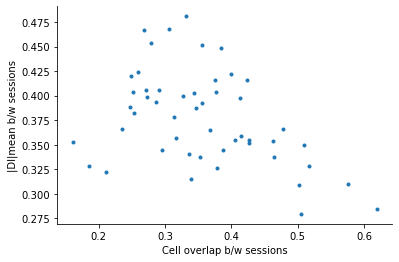

In [16]:
fig, ax = plt.subplots()
ax.plot(overlaps, DIabs_mean, '.')
ax.set_xlabel('Cell overlap b/w sessions')
ax.set_ylabel('|DI|mean b/w sessions')
sns.despine(ax=ax)

r, p = stats.spearmanr(overlaps, DIabs_mean, nan_policy='omit')
print('\033[4mSpearman Correlation\033[0m')
print('r = ' + str(r))
print('p = ' + str(p))

Ok, so these metrics are correlated.

No placefields file found - creating PV1 from neural data only - NO SPEED THRESHOLDING
Marble14 bad open-field tracking data from days 0-7 skipped
No placefields file found - creating PV1 from neural data only - NO SPEED THRESHOLDING
Marble14 bad open-field tracking data from days 0-7 skipped
No placefields file found - creating PV1 from neural data only - NO SPEED THRESHOLDING
Marble14 bad open-field tracking data from days 0-7 skipped
Spearman Correlation
r = 0.47700462314525494
p = 0.013741472978836891


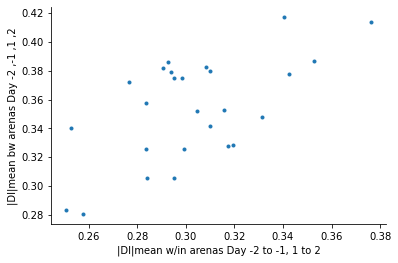

In [17]:
ax, drift_win_all, drift_bw_all = pfg.drift_time_v_context(day_pairs=[[-2, -1], [1, 2]], drift_metric='event_rate', speed_thresh=0)

# Figure plot above

In [18]:
# Still significant even if I exclude 2 biggest points (one mouse)? No.
ioutlier = np.where(np.asarray(drift_bw_all) > 0.4)[0]
npts = len(drift_win_all)
good_bool = np.ones(npts).astype('bool')
good_bool[ioutlier] = 0
r2, p2 = stats.spearmanr(np.asarray(drift_win_all)[good_bool], np.asarray(drift_bw_all)[good_bool])

print('\033[4mSpearman Correlation\033[0m')
print('r = ' + str(r2))
print('p = ' + str(p2))

Spearman Correlation
r = 0.3444227087291567
p = 0.09932829963531915


What does this look like for individual mice?

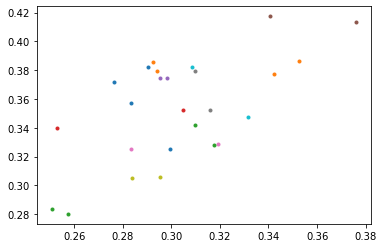

In [19]:
# Color each set of points by mouse
fig, ax = plt.subplots()
for dwin, dbw in zip(np.asarray(drift_win_all).reshape(-1, 2), np.asarray(drift_bw_all).reshape(-1, 2)):
    ax.plot(dwin, dbw, '.')

What about if we add in an extra set of days?

No placefields file found - creating PV1 from neural data only - NO SPEED THRESHOLDING
No placefields file found - creating PV1 from neural data only - NO SPEED THRESHOLDING
No placefields file found - creating PV1 from neural data only - NO SPEED THRESHOLDING
No placefields file found - creating PV1 from neural data only - NO SPEED THRESHOLDING
No placefields file found - creating PV1 from neural data only - NO SPEED THRESHOLDING
Marble14 bad open-field tracking data from days 0-7 skipped
No placefields file found - creating PV1 from neural data only - NO SPEED THRESHOLDING
Marble14 bad open-field tracking data from days 0-7 skipped
No placefields file found - creating PV1 from neural data only - NO SPEED THRESHOLDING
Marble14 bad open-field tracking data from days 0-7 skipped
No placefields file found - creating PV1 from neural data only - NO SPEED THRESHOLDING
Marble14 bad open-field tracking data from days 0-7 skipped
No placefields file found - creating PV1 from neural data only -

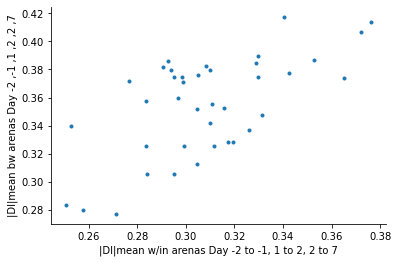

In [20]:
ax, drift_win_all, drift_bw_all = pfg.drift_time_v_context(day_pairs=[[-2, -1], [1, 2], [2, 7]], drift_metric='event_rate', speed_thresh=0)

In [21]:
# Still significant even if I exclude the biggest points?
ioutlier = np.where(np.asarray(drift_bw_all) > 0.4)[0]
npts = len(drift_win_all)
good_bool = np.ones(npts).astype('bool')
good_bool[ioutlier] = 0
r2, p2 = stats.spearmanr(np.asarray(drift_win_all)[good_bool], np.asarray(drift_bw_all)[good_bool])

print('\033[4mSpearman Correlation\033[0m')
print('r = ' + str(r2))
print('p = ' + str(p2))

Spearman Correlation
r = 0.3882595391302571
p = 0.019284863870161


Ok, so this is cool! Very significant with more data points, though the above code is technically double-counting day 2 since I incude each day of a given day-pair for the "between" comparison.  Go back and re-work code to only include FIRST or SECOND day for between arena drift. This would explicitly test whether between arena drift predicts across days drift and vice versa, respectively. 

Test rewritten code below.

No placefields file found - creating PV1 from neural data only - NO SPEED THRESHOLDING
No placefields file found - creating PV1 from neural data only - NO SPEED THRESHOLDING
No placefields file found - creating PV1 from neural data only - NO SPEED THRESHOLDING
No placefields file found - creating PV1 from neural data only - NO SPEED THRESHOLDING
No placefields file found - creating PV1 from neural data only - NO SPEED THRESHOLDING
Marble14 bad open-field tracking data from days 0-7 skipped
No placefields file found - creating PV1 from neural data only - NO SPEED THRESHOLDING
Marble14 bad open-field tracking data from days 0-7 skipped
No placefields file found - creating PV1 from neural data only - NO SPEED THRESHOLDING
Marble14 bad open-field tracking data from days 0-7 skipped
No placefields file found - creating PV1 from neural data only - NO SPEED THRESHOLDING
Marble14 bad open-field tracking data from days 0-7 skipped
No placefields file found - creating PV1 from neural data only -

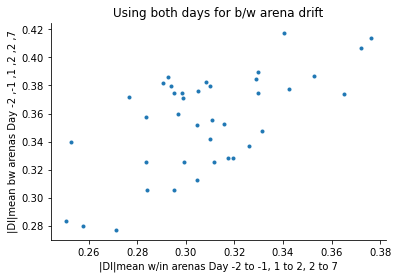

In [22]:
ax, drift_win_all, drift_bw_all = pfg.drift_time_v_context(day_pairs=[[-2, -1], [1, 2], [2, 7]], drift_metric='event_rate', speed_thresh=0, bw_day_use='both')

No placefields file found - creating PV1 from neural data only - NO SPEED THRESHOLDING
No placefields file found - creating PV1 from neural data only - NO SPEED THRESHOLDING
No placefields file found - creating PV1 from neural data only - NO SPEED THRESHOLDING
Marble14 bad open-field tracking data from days 0-7 skipped
No placefields file found - creating PV1 from neural data only - NO SPEED THRESHOLDING
Marble14 bad open-field tracking data from days 0-7 skipped
No placefields file found - creating PV1 from neural data only - NO SPEED THRESHOLDING
Marble14 bad open-field tracking data from days 0-7 skipped
No placefields file found - creating PV1 from neural data only - NO SPEED THRESHOLDING
Marble14 bad open-field tracking data from days 0-7 skipped
Spearman Correlation
r = 0.4943100995732575
p = 0.0018729700095892607


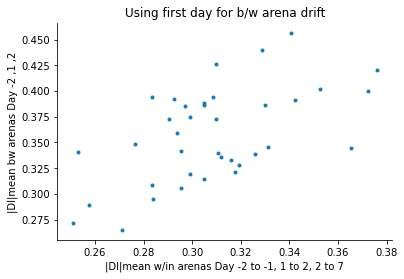

In [26]:
ax, drift_win_all, drift_bw_all = pfg.drift_time_v_context(day_pairs=[[-2, -1], [1, 2], [2, 7]], drift_metric='event_rate', speed_thresh=0, bw_day_use='first')

No placefields file found - creating PV1 from neural data only - NO SPEED THRESHOLDING
No placefields file found - creating PV1 from neural data only - NO SPEED THRESHOLDING
No placefields file found - creating PV1 from neural data only - NO SPEED THRESHOLDING
No placefields file found - creating PV1 from neural data only - NO SPEED THRESHOLDING
No placefields file found - creating PV1 from neural data only - NO SPEED THRESHOLDING
Marble14 bad open-field tracking data from days 0-7 skipped
No placefields file found - creating PV1 from neural data only - NO SPEED THRESHOLDING
Marble14 bad open-field tracking data from days 0-7 skipped
No placefields file found - creating PV1 from neural data only - NO SPEED THRESHOLDING
Marble14 bad open-field tracking data from days 0-7 skipped
No placefields file found - creating PV1 from neural data only - NO SPEED THRESHOLDING
Marble14 bad open-field tracking data from days 0-7 skipped
Spearman Correlation
r = 0.31721194879089615
p = 0.0557437943097

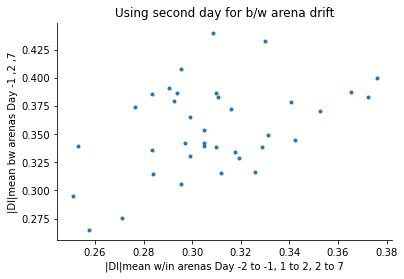

In [27]:
ax, drift_win_all, drift_bw_all = pfg.drift_time_v_context(day_pairs=[[-2, -1], [1, 2], [2, 7]], drift_metric='event_rate', speed_thresh=0, bw_day_use='second')

Ok, so this holds up more-or-less when I look at it for one day of the `day_pair` only. But it seems stronger that between arena drift on a given day predicts across day drift.

# Plot figure(s) above